# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

## Submodule: diffractionshifts

This notebook demos measuring and correction shifts of the diffraction patterns due to the scanning of the beam in real space.  This notebook requires that the Bragg peaks and average deconvolution have already been measured. We proceed as follows:

Measure diffraction shifts
1. For each scan position, find the Bragg peak closest to the center of mass of the average deconvolution; these are the initial guess for the diffraction shifts
2. Determine which, if any, of these shifts are incorrect by detecting outliers
3. Ignoring outliers, fit a plane or parabola to the initial guess - these are the diffraction shifts

Correct diffraction shifts
1. Apply shifts to the Bragg peak positions. Recalculate and display the average deconvolution.
2. (optional) Apply shifts to the data, creating a new, shifte corrected datacube. Note that this requires having sufficient memory, and is frequenly not necessary.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
import numpy.ma as ma

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.readwrite import FileBrowser, read, append
from py4DSTEM.process.braggdiskdetection import get_deconvolution

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution                       DiffractionSlice    
   2    deconvolution_1                     DiffractionSlice    
   3    deconvolution_shiftcorrected        DiffractionSlice    
   4    deconvolution_uncorrected           DiffractionSlice    
   5    diffractionslice_3                  DiffractionSlice    
   6    probe_kernel                        DiffractionSlice    
   7    DF_image                            RealSlice           
   8    DF_image_1                          RealSlice           
   9    diffraction_shifts                  RealSlice           
   10   diffraction_shifts_1                RealSlice           
   11   realslice_0                         RealSlice           
   12   strain_maps                         RealSlice           
   13   strain_maps_1                       RealSlice           
   14   uv_map           

In [3]:
# Load data

dc = browser.get_dataobject('datacube')
Braggpeak_pointlistarray = browser.get_dataobject('Braggpeaks')
average_deconvolution = browser.get_dataobject('deconvolution_uncorrected').data2D
browser.close()

### Determine diffraction shifts

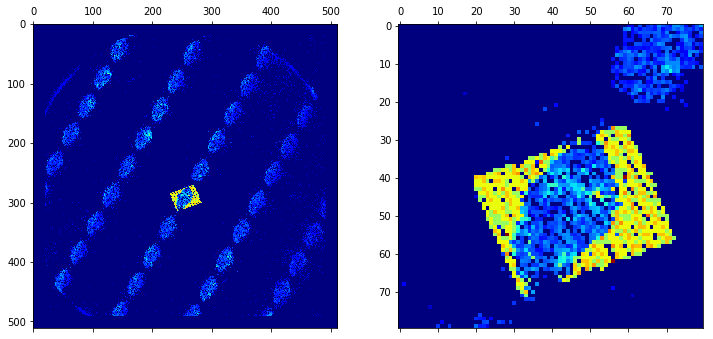

In [4]:
# Show
x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution)
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(average_deconvolution**0.25,cmap='jet')
ax2.matshow(average_deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

In [5]:
# Get the BP closest to the deconvolution CoM for each scan position

rad=50

x0,y0 = py4DSTEM.process.utils.get_CoM(average_deconvolution)
diffraction_shifts_0 = RealSlice(data=np.empty((dc.R_Nx,dc.R_Ny,2)), slicelabels=('x','y'))
candidate_peaks = np.zeros_like(average_deconvolution)

for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        pointlist = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        
        r2 = (pointlist.data['qx']-x0)**2 + (pointlist.data['qy']-y0)**2
        index = np.argmin(r2)
        diffraction_shifts_0.data2D['x'][Rx,Ry] = pointlist.data['qx'][index]
        diffraction_shifts_0.data2D['y'][Rx,Ry] = pointlist.data['qy'][index]
        candidate_peaks[int(pointlist.data['qx'][index]),int(pointlist.data['qy'][index])] += pointlist.data['intensity'][index]

In [6]:
# Get the BP closest to the deconvolution CoM for each scan position

rad=50

# Initial pass
x0,y0 = py4DSTEM.process.utils.get_CoM(average_deconvolution)
candidate_peaks = np.zeros_like(average_deconvolution)
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        pointlist = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)        
        r2 = (pointlist.data['qx']-x0)**2 + (pointlist.data['qy']-y0)**2
        index = np.argmin(r2)
        candidate_peaks[int(pointlist.data['qx'][index]),int(pointlist.data['qy'][index])] += pointlist.data['intensity'][index]
        
# Refinement
x0,y0 = py4DSTEM.process.utils.get_CoM(candidate_peaks)
candidate_peaks = np.zeros_like(average_deconvolution)
diffraction_shifts_0 = RealSlice(data=np.empty((dc.R_Nx,dc.R_Ny,2)), slicelabels=('x','y'))
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        pointlist = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        
        r2 = (pointlist.data['qx']-x0)**2 + (pointlist.data['qy']-y0)**2
        index = np.argmin(r2)
        diffraction_shifts_0.data2D['x'][Rx,Ry] = pointlist.data['qx'][index]
        diffraction_shifts_0.data2D['y'][Rx,Ry] = pointlist.data['qy'][index]
        candidate_peaks[int(pointlist.data['qx'][index]),int(pointlist.data['qy'][index])] += pointlist.data['intensity'][index]

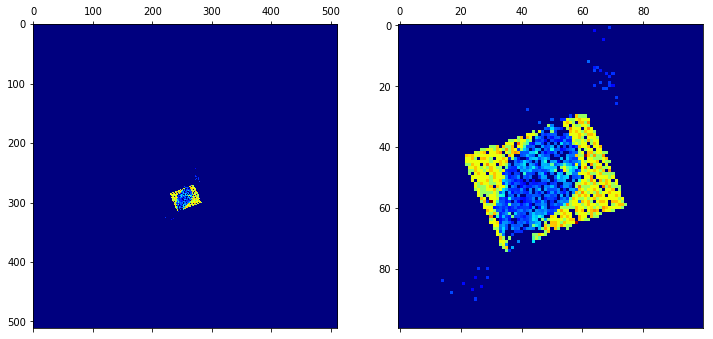

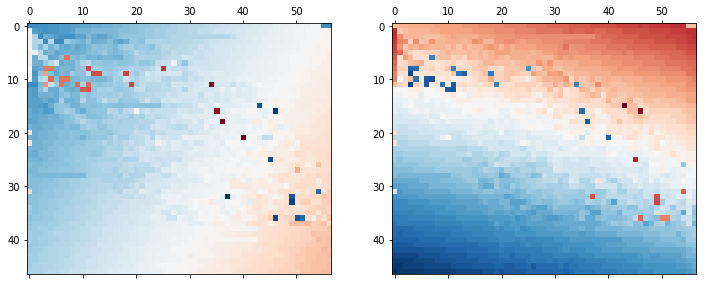

In [7]:
# Show candidate peaks and initial guess at diffraction shifts

x0,y0 = py4DSTEM.process.utils.get_CoM(candidate_peaks)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(candidate_peaks**0.25,cmap='jet')
ax2.matshow(candidate_peaks[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**0.25,cmap='jet')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(diffraction_shifts_0.data2D['x'],cmap="RdBu")
ax2.matshow(diffraction_shifts_0.data2D['y'],cmap="RdBu")
plt.show()

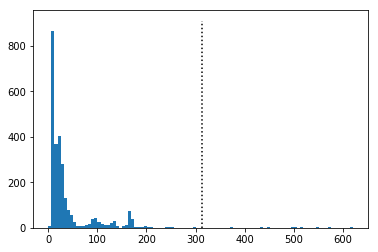

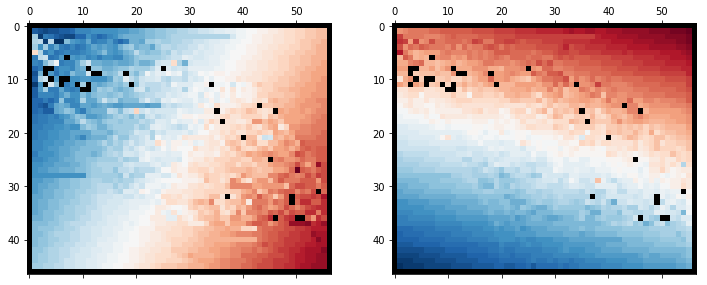

In [8]:
# Find outliers

n_bins = 100
n_sigma = 3
edge_boundary = 1

# Get scores with respect to NNs
NNdiff = np.zeros_like(diffraction_shifts_0.data2D['x'])
NNdiff += np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(-1,0),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(1,0),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(0,-1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(0,1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(-1,-1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(-1,1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(1,-1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['x'] - np.roll(diffraction_shifts_0.data2D['x'],(1,1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(-1,0),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(1,0),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(0,-1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(0,1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(-1,-1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(-1,1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(1,-1),axis=(0,1))) + \
          np.abs(diffraction_shifts_0.data2D['y'] - np.roll(diffraction_shifts_0.data2D['y'],(1,1),axis=(0,1)))

# Make histogram
bins = np.linspace(0,np.max(NNdiff),n_bins)
n,bins = np.histogram(NNdiff,bins=bins)
width = bins[1]-bins[0]

# Fit lognormal function
fitfunc = lambda p,x: p[0] * np.exp(-0.5*((x-p[0])/p[2])**2)
errfunc = lambda p,x,y: fitfunc(p,x) - y
p0_0 = np.max(gaussian_filter(n,2))
p0_1 = np.average(bins[:-1]+width/2.,weights=n)
p0_2 = np.sqrt(np.sum((bins[:-1]+width/2. - p0_1)**2)/(len(bins[:-1])-1))
p0 = [p0_0,p0_1,p0_2]
p1,success = leastsq(errfunc, p0, args=(bins[:-1]+width/2.,n))

# Set cutoff, make mask and masked arrays
std = p1[2]
cutoff = std*n_sigma
mask = NNdiff > cutoff
mask[:edge_boundary,:] = True
mask[-edge_boundary:,:] = True
mask[:,:edge_boundary] = True
mask[:,-edge_boundary:] = True
diffraction_shifts_x_masked = ma.masked_array(diffraction_shifts_0.data2D['x'], mask)
diffraction_shifts_y_masked = ma.masked_array(diffraction_shifts_0.data2D['y'], mask)
mask_display = ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+width/2., n, width, align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(diffraction_shifts_x_masked,cmap="RdBu")
ax2.matshow(diffraction_shifts_y_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

### Fit diffraction shifts

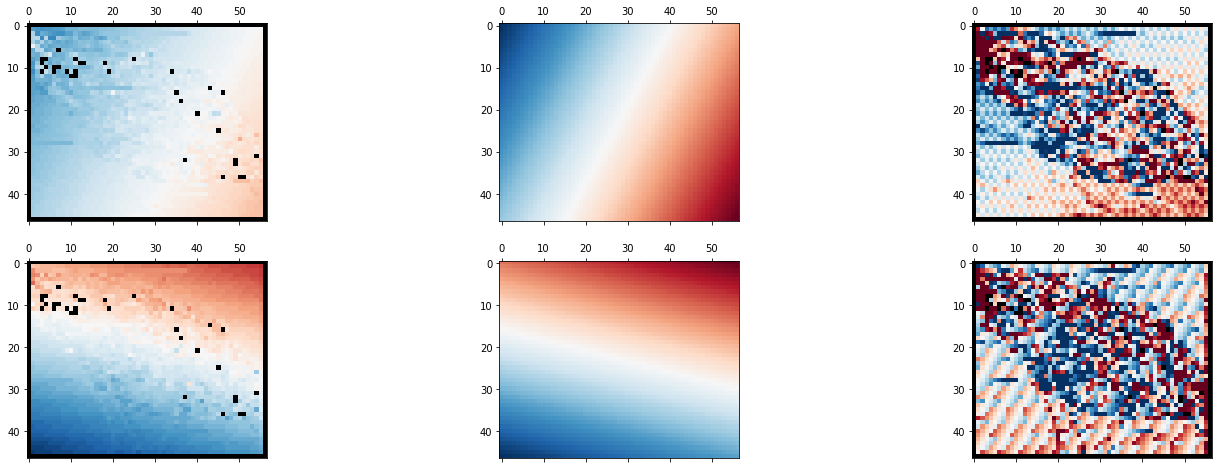

In [9]:
# Fit with only datapoints where diffraction_shifts_known==True

fit_function = py4DSTEM.process.fit.plane
#fit_function = py4DSTEM.process.fit.parabola

diffraction_shifts = RealSlice(data=np.zeros((dc.R_Nx,dc.R_Ny,2)),
                               slicelabels=('x','y'), name='diffraction_shifts')

popt_x, pcov_x, diffraction_shifts.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts_x_masked.data, data_mask=mask==False)
popt_y, pcov_y, diffraction_shifts.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts_y_masked.data, data_mask=mask==False)

residuals_x = diffraction_shifts_x_masked.data-diffraction_shifts.data2D['x']
residuals_x[mask] = 0
residuals_y = diffraction_shifts_y_masked.data-diffraction_shifts.data2D['y']
residuals_y[mask] = 0

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,8))
ax11.matshow(diffraction_shifts_x_masked.data,cmap="RdBu")
ax21.matshow(diffraction_shifts_y_masked.data,cmap="RdBu")
ax12.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax22.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

In [10]:
# Subtract off average

diffraction_shifts.data2D['x'] -= np.average(diffraction_shifts.data2D['x'])
diffraction_shifts.data2D['y'] -= np.average(diffraction_shifts.data2D['y'])

### Apply shifts, calculate shift-corrected deconvolution

In [11]:
# Apply shifts to Bragg peak list

shifted_Braggpeak_pointlistarray = Braggpeak_pointlistarray.copy(name="shifted_Braggpeaks")

for Rx in range(shifted_Braggpeak_pointlistarray.shape[0]):
    for Ry in range(shifted_Braggpeak_pointlistarray.shape[1]):
        pointlist = shifted_Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        shift_qx = int(diffraction_shifts.data2D['x'][Rx,Ry])
        shift_qy = int(diffraction_shifts.data2D['y'][Rx,Ry])
        pointlist.data['qx'] -= shift_qx
        pointlist.data['qy'] -= shift_qy

In [12]:
# Re-calculate average deconvolution

deconvolution = get_deconvolution(shifted_Braggpeak_pointlistarray,dc.Q_Nx,dc.Q_Ny)

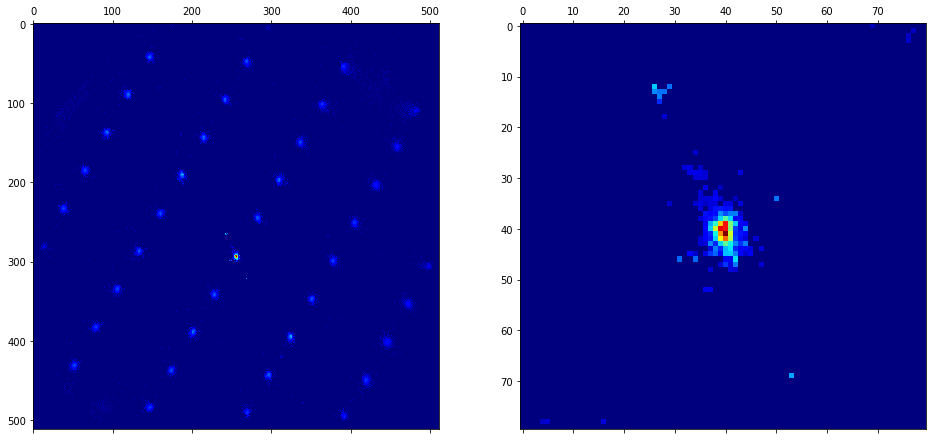

In [13]:
# Plot

x0,y0=np.unravel_index(np.argmax(gaussian_filter(deconvolution,2)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**0.25,cmap='jet')
ax2.matshow(deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

### (Optional) Create shift-corrected 4D datacube

In [20]:
# Apply shifts

data4D_corrected = np.empty_like(dc.data4D,dtype='float32')

t0=time()
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Shifting DP from scan position {},{}".format(i,j))
        data4D_corrected[i,j,:,:] = py4DSTEM.process.utils.get_shifted_ar(dc.data4D[i,j,:,:], 
                                                   -diffraction_shifts_fit.data2D['x'][i,j],
                                                   -diffraction_shifts_fit.data2D['y'][i,j])

t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Shifting DP from scan position 0,0
Shifting DP from scan position 0,1
Shifting DP from scan position 0,2
Shifting DP from scan position 0,3
Shifting DP from scan position 0,4
Shifting DP from scan position 0,5
Shifting DP from scan position 0,6
Shifting DP from scan position 0,7
Shifting DP from scan position 0,8
Shifting DP from scan position 0,9
Shifting DP from scan position 0,10
Shifting DP from scan position 0,11
Shifting DP from scan position 0,12
Shifting DP from scan position 0,13
Shifting DP from scan position 0,14
Shifting DP from scan position 0,15
Shifting DP from scan position 0,16
Shifting DP from scan position 0,17
Shifting DP from scan position 0,18
Shifting DP from scan position 0,19
Shifting DP from scan position 0,20
Shifting DP from scan position 0,21
Shifting DP from scan position 0,22
Shifting DP from scan position 0,23
Shifting DP from scan position 0,24
Shifting DP from scan position 0,25
Shifting DP from scan position 0,26
Shifting DP from scan position 0,27
Sh

Shifting DP from scan position 4,5
Shifting DP from scan position 4,6
Shifting DP from scan position 4,7
Shifting DP from scan position 4,8
Shifting DP from scan position 4,9
Shifting DP from scan position 4,10
Shifting DP from scan position 4,11
Shifting DP from scan position 4,12
Shifting DP from scan position 4,13
Shifting DP from scan position 4,14
Shifting DP from scan position 4,15
Shifting DP from scan position 4,16
Shifting DP from scan position 4,17
Shifting DP from scan position 4,18
Shifting DP from scan position 4,19
Shifting DP from scan position 4,20
Shifting DP from scan position 4,21
Shifting DP from scan position 4,22
Shifting DP from scan position 4,23
Shifting DP from scan position 4,24
Shifting DP from scan position 4,25
Shifting DP from scan position 4,26
Shifting DP from scan position 4,27
Shifting DP from scan position 4,28
Shifting DP from scan position 4,29
Shifting DP from scan position 4,30
Shifting DP from scan position 4,31
Shifting DP from scan position 4,

Shifting DP from scan position 8,11
Shifting DP from scan position 8,12
Shifting DP from scan position 8,13
Shifting DP from scan position 8,14
Shifting DP from scan position 8,15
Shifting DP from scan position 8,16
Shifting DP from scan position 8,17
Shifting DP from scan position 8,18
Shifting DP from scan position 8,19
Shifting DP from scan position 8,20
Shifting DP from scan position 8,21
Shifting DP from scan position 8,22
Shifting DP from scan position 8,23
Shifting DP from scan position 8,24
Shifting DP from scan position 8,25
Shifting DP from scan position 8,26
Shifting DP from scan position 8,27
Shifting DP from scan position 8,28
Shifting DP from scan position 8,29
Shifting DP from scan position 8,30
Shifting DP from scan position 8,31
Shifting DP from scan position 8,32
Shifting DP from scan position 8,33
Shifting DP from scan position 8,34
Shifting DP from scan position 8,35
Shifting DP from scan position 8,36
Shifting DP from scan position 8,37
Shifting DP from scan positi

Shifting DP from scan position 12,10
Shifting DP from scan position 12,11
Shifting DP from scan position 12,12
Shifting DP from scan position 12,13
Shifting DP from scan position 12,14
Shifting DP from scan position 12,15
Shifting DP from scan position 12,16
Shifting DP from scan position 12,17
Shifting DP from scan position 12,18
Shifting DP from scan position 12,19
Shifting DP from scan position 12,20
Shifting DP from scan position 12,21
Shifting DP from scan position 12,22
Shifting DP from scan position 12,23
Shifting DP from scan position 12,24
Shifting DP from scan position 12,25
Shifting DP from scan position 12,26
Shifting DP from scan position 12,27
Shifting DP from scan position 12,28
Shifting DP from scan position 12,29
Shifting DP from scan position 12,30
Shifting DP from scan position 12,31
Shifting DP from scan position 12,32
Shifting DP from scan position 12,33
Shifting DP from scan position 12,34
Shifting DP from scan position 12,35
Shifting DP from scan position 12,36
S

Shifting DP from scan position 16,8
Shifting DP from scan position 16,9
Shifting DP from scan position 16,10
Shifting DP from scan position 16,11
Shifting DP from scan position 16,12
Shifting DP from scan position 16,13
Shifting DP from scan position 16,14
Shifting DP from scan position 16,15
Shifting DP from scan position 16,16
Shifting DP from scan position 16,17
Shifting DP from scan position 16,18
Shifting DP from scan position 16,19
Shifting DP from scan position 16,20
Shifting DP from scan position 16,21
Shifting DP from scan position 16,22
Shifting DP from scan position 16,23
Shifting DP from scan position 16,24
Shifting DP from scan position 16,25
Shifting DP from scan position 16,26
Shifting DP from scan position 16,27
Shifting DP from scan position 16,28
Shifting DP from scan position 16,29
Shifting DP from scan position 16,30
Shifting DP from scan position 16,31
Shifting DP from scan position 16,32
Shifting DP from scan position 16,33
Shifting DP from scan position 16,34
Shi

Shifting DP from scan position 20,8
Shifting DP from scan position 20,9
Shifting DP from scan position 20,10
Shifting DP from scan position 20,11
Shifting DP from scan position 20,12
Shifting DP from scan position 20,13
Shifting DP from scan position 20,14
Shifting DP from scan position 20,15
Shifting DP from scan position 20,16
Shifting DP from scan position 20,17
Shifting DP from scan position 20,18
Shifting DP from scan position 20,19
Shifting DP from scan position 20,20
Shifting DP from scan position 20,21
Shifting DP from scan position 20,22
Shifting DP from scan position 20,23
Shifting DP from scan position 20,24
Shifting DP from scan position 20,25
Shifting DP from scan position 20,26
Shifting DP from scan position 20,27
Shifting DP from scan position 20,28
Shifting DP from scan position 20,29
Shifting DP from scan position 20,30
Shifting DP from scan position 20,31
Shifting DP from scan position 20,32
Shifting DP from scan position 20,33
Shifting DP from scan position 20,34
Shi

Shifting DP from scan position 24,5
Shifting DP from scan position 24,6
Shifting DP from scan position 24,7
Shifting DP from scan position 24,8
Shifting DP from scan position 24,9
Shifting DP from scan position 24,10
Shifting DP from scan position 24,11
Shifting DP from scan position 24,12
Shifting DP from scan position 24,13
Shifting DP from scan position 24,14
Shifting DP from scan position 24,15
Shifting DP from scan position 24,16
Shifting DP from scan position 24,17
Shifting DP from scan position 24,18
Shifting DP from scan position 24,19
Shifting DP from scan position 24,20
Shifting DP from scan position 24,21
Shifting DP from scan position 24,22
Shifting DP from scan position 24,23
Shifting DP from scan position 24,24
Shifting DP from scan position 24,25
Shifting DP from scan position 24,26
Shifting DP from scan position 24,27
Shifting DP from scan position 24,28
Shifting DP from scan position 24,29
Shifting DP from scan position 24,30
Shifting DP from scan position 24,31
Shifti

Shifting DP from scan position 28,9
Shifting DP from scan position 28,10
Shifting DP from scan position 28,11
Shifting DP from scan position 28,12
Shifting DP from scan position 28,13
Shifting DP from scan position 28,14
Shifting DP from scan position 28,15
Shifting DP from scan position 28,16
Shifting DP from scan position 28,17
Shifting DP from scan position 28,18
Shifting DP from scan position 28,19
Shifting DP from scan position 28,20
Shifting DP from scan position 28,21
Shifting DP from scan position 28,22
Shifting DP from scan position 28,23
Shifting DP from scan position 28,24
Shifting DP from scan position 28,25
Shifting DP from scan position 28,26
Shifting DP from scan position 28,27
Shifting DP from scan position 28,28
Shifting DP from scan position 28,29
Shifting DP from scan position 28,30
Shifting DP from scan position 28,31
Shifting DP from scan position 28,32
Shifting DP from scan position 28,33
Shifting DP from scan position 28,34
Shifting DP from scan position 28,35
Sh

Shifting DP from scan position 32,9
Shifting DP from scan position 32,10
Shifting DP from scan position 32,11
Shifting DP from scan position 32,12
Shifting DP from scan position 32,13
Shifting DP from scan position 32,14
Shifting DP from scan position 32,15
Shifting DP from scan position 32,16
Shifting DP from scan position 32,17
Shifting DP from scan position 32,18
Shifting DP from scan position 32,19
Shifting DP from scan position 32,20
Shifting DP from scan position 32,21
Shifting DP from scan position 32,22
Shifting DP from scan position 32,23
Shifting DP from scan position 32,24
Shifting DP from scan position 32,25
Shifting DP from scan position 32,26
Shifting DP from scan position 32,27
Shifting DP from scan position 32,28
Shifting DP from scan position 32,29
Shifting DP from scan position 32,30
Shifting DP from scan position 32,31
Shifting DP from scan position 32,32
Shifting DP from scan position 32,33
Shifting DP from scan position 32,34
Shifting DP from scan position 32,35
Sh

Shifting DP from scan position 36,9
Shifting DP from scan position 36,10
Shifting DP from scan position 36,11
Shifting DP from scan position 36,12
Shifting DP from scan position 36,13
Shifting DP from scan position 36,14
Shifting DP from scan position 36,15
Shifting DP from scan position 36,16
Shifting DP from scan position 36,17
Shifting DP from scan position 36,18
Shifting DP from scan position 36,19
Shifting DP from scan position 36,20
Shifting DP from scan position 36,21
Shifting DP from scan position 36,22
Shifting DP from scan position 36,23
Shifting DP from scan position 36,24
Shifting DP from scan position 36,25
Shifting DP from scan position 36,26
Shifting DP from scan position 36,27
Shifting DP from scan position 36,28
Shifting DP from scan position 36,29
Shifting DP from scan position 36,30
Shifting DP from scan position 36,31
Shifting DP from scan position 36,32
Shifting DP from scan position 36,33
Shifting DP from scan position 36,34
Shifting DP from scan position 36,35
Sh

Shifting DP from scan position 40,13
Shifting DP from scan position 40,14
Shifting DP from scan position 40,15
Shifting DP from scan position 40,16
Shifting DP from scan position 40,17
Shifting DP from scan position 40,18
Shifting DP from scan position 40,19
Shifting DP from scan position 40,20
Shifting DP from scan position 40,21
Shifting DP from scan position 40,22
Shifting DP from scan position 40,23
Shifting DP from scan position 40,24
Shifting DP from scan position 40,25
Shifting DP from scan position 40,26
Shifting DP from scan position 40,27
Shifting DP from scan position 40,28
Shifting DP from scan position 40,29
Shifting DP from scan position 40,30
Shifting DP from scan position 40,31
Shifting DP from scan position 40,32
Shifting DP from scan position 40,33
Shifting DP from scan position 40,34
Shifting DP from scan position 40,35
Shifting DP from scan position 40,36
Shifting DP from scan position 40,37
Shifting DP from scan position 40,38
Shifting DP from scan position 40,39
S

Shifting DP from scan position 44,9
Shifting DP from scan position 44,10
Shifting DP from scan position 44,11
Shifting DP from scan position 44,12
Shifting DP from scan position 44,13
Shifting DP from scan position 44,14
Shifting DP from scan position 44,15
Shifting DP from scan position 44,16
Shifting DP from scan position 44,17
Shifting DP from scan position 44,18
Shifting DP from scan position 44,19
Shifting DP from scan position 44,20
Shifting DP from scan position 44,21
Shifting DP from scan position 44,22
Shifting DP from scan position 44,23
Shifting DP from scan position 44,24
Shifting DP from scan position 44,25
Shifting DP from scan position 44,26
Shifting DP from scan position 44,27
Shifting DP from scan position 44,28
Shifting DP from scan position 44,29
Shifting DP from scan position 44,30
Shifting DP from scan position 44,31
Shifting DP from scan position 44,32
Shifting DP from scan position 44,33
Shifting DP from scan position 44,34
Shifting DP from scan position 44,35
Sh

In [19]:
# Store new, shifted datacube
datacube_shifted = py4DSTEM.process.datastructure.DataCube(data=data4D_corrected,
                                                           parentDataCube=dc, 
                                                           name="shift_corrected_datacube")